In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

## 1. Data
##### Data Dictionary
company<br>
    - String, company names

description<br>
    - String, full text description of job

estimated_salary<br>
    - String, Indeed's salary estimation

extractDate<br>
    - String(?), date record was webscrapped

job_type_items<br>
    - String, formatted list of 'full-time', 'part-time', etc

location<br>
    - String, state and city/remote

postDate<br>
    - String, date job posting was created

rating<br>
    - Float, Indeed.com ascribed company ratings

raw_desc_soup<br>
    - String, raw full description, retained for possible future use/analysis

requirements<br>
    - String, employer-listed educational, aptitude, and experience requirements

sal_guide_items<br>
    - String, formatted list containing redundant characters and the Indeed salary estimate

salary<br>
    - String, if given by employer

salary_and_jType<br>
    - String, formatted list combining salary from salfromsection and job_type_items

salfromsection<br>
    - String, salary, if given, extracted from job description

summary<br>
    - String, brief summaries of each job extracted from sach results

title<br>
    - String, job position title

url<br>
    - String, job posting/description address

### 1.1 Load & Inspect Data

In [2]:
data = pd.read_csv('../app/data/total.csv')
# 1.1.1 Inspect Table
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           377 non-null    object 
 1   description       369 non-null    object 
 2   estimated_salary  130 non-null    object 
 3   extractDate       377 non-null    object 
 4   job_type_items    33 non-null     object 
 5   location          377 non-null    object 
 6   postDate          377 non-null    object 
 7   rating            229 non-null    float64
 8   raw_desc_soup     375 non-null    object 
 9   requirements      6 non-null      object 
 10  sal_guide_items   129 non-null    object 
 11  salary            69 non-null     object 
 12  salary_and_jType  227 non-null    object 
 13  salfromsection    64 non-null     object 
 14  summary           377 non-null    object 
 15  title             377 non-null    object 
 16  url               377 non-null    object 
dt

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,Recruiting From Scratch,Who is Recruiting from Scratch: Recruiting fro...,NaN,2022-06-21,NaN,"Remote in Huntsville, AL",PostedToday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$160,000 - $200,000 a year","$160,000 - $200,000 a year","$160,000 - $200,000 a year",5+ years experience in data engineering or dat...,Data Scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...
1,Food Management Search,SR Financial Data Analyst- Fully remote - ANY ...,NaN,2022-06-21,NaN,Remote in United States,PostedToday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,NaN,NaN,Lead various allocation data analysis projects...,SR Financial Data Analyst- Fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,Gregor Diagnostics,Role: Senior Data ScientistAbout Gregor Diagno...,NaN,2022-06-21,NaN,Remote in United States,PostedPosted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,Full-time,NaN,The Senior Data Scientist will work closely la...,Senior Data Scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
3,SynergisticIT,"At SynergisticIT, we aim to bring aboard IT ...",Estimated $77.7K - $98.3K a year,2022-06-21,NaN,Alabama,PostedPosted 1 day ago,4.2,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$77.7K - $98...",NaN,"Full-time, Contract",NaN,"Collaborate with dynamic teams of engineers, d...",Entry Level Data Scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...
4,9Rooftops,WE ARE HIRING IN MULTIPLE LOCATIONS ACROSS THE...,Estimated $109K - $138K a year,2022-06-21,NaN,"Birmingham, AL 35242",PostedPosted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$109K - $138...",NaN,NaN,NaN,O Communication skills to ask questions of cli...,Statistician/Data Scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...


In [3]:
print(data.salary[-10:])

367                           NaN
368                           NaN
369                           NaN
370                           NaN
371                           NaN
372                           NaN
373                           NaN
374                           NaN
375                           NaN
376    $160,000 - $200,000 a year
Name: salary, dtype: object


In [4]:
null = sum(data.salary.isnull())
nnull = sum(data.salary.notnull())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')


The data contains 377 rows of individual job postings with values for 17 columns based on
 different sections of each post's web page.

- Out of 377 job postings 69 or 18.3% include some sort of salary information,
- The remaining 308 rowws, or 81.7% are missing salary data.
- Also, there are no null values in the rest of the table meaning we won't need
  to lose any data by dropping rows. While the null values in the Pay column will
  simply be dropped after we translate the not nulls into the target.


    The following table is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.

In [5]:
shape = data.shape
print(f"The {shape[0]} rows of data have {shape[1]} features. Since this is a classification problem I'll be selecting one to be the target, leaving me with {shape[1]-1} features to work with.")

The 377 rows of data have 17 features. Since this is a classification problem I'll be selecting one to be the target, leaving me with 16 features to work with.


In [6]:
#check for dupes
print(len(data[data.duplicated()]))


0


In [7]:
data[data.company == 'The Getch']

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url


In [8]:
data.sal_guide_items[-5:-4]

372    NaN
Name: sal_guide_items, dtype: object

In [9]:
#check for missing
print(data.isna().sum().sort_values(ascending=False))

requirements        371
job_type_items      344
salfromsection      313
salary              308
sal_guide_items     248
estimated_salary    247
salary_and_jType    150
rating              148
description           8
raw_desc_soup         2
title                 0
summary               0
company               0
postDate              0
location              0
extractDate           0
url                   0
dtype: int64


The likelihood of seeing duplicates coming from the raw scrapping is very unlikely, but this is still a good check to do in case something changes with Indeed.com's front-end code.

Missing values are another story. It seems that Indeed.com doesn't require employers to provide values for every feature, this certainly seems to be the case with requirements, not to mention everywhere salary information coud be held.\
Others, like estimated salary and ratings are generated by Indeed.com but don't exist for every posting.\
job_type_items and salary_and_jType will likely be collapsed into a new column for job types, I'll also do the same with all of the salary related features to build the model's target.

In [10]:
# 1.1.2 Inspect & Modify Columns
data.nunique().sort_values(ascending=False)


raw_desc_soup       373
url                 203
location            104
summary              96
description          93
title                84
company              75
sal_guide_items      44
estimated_salary     35
salary_and_jType     19
salary               17
rating               15
salfromsection       15
requirements          5
postDate              4
job_type_items        3
extractDate           1
dtype: int64

In [11]:
data.columns = map(str.lower, data.columns)
# no need to change many column names because they're about to be dropped.
data = data.rename({'title': 'job_title'}, axis=1)

## 2. Preprocesing A
### 2.1 Reinspect Data

In [12]:
data.salary.unique()

array(['$160,000 - $200,000 a year', nan, '$164,000 - $238,000 a year',
       '$70,000 - $85,000 a year', '$125,000 - $145,000 a year',
       '$111,600 - $167,400 a year', '$60 - $70 an hour',
       '$55 - $90 an hour', '$95,000 - $120,000 a year',
       '$85,000 - $170,000 a year', '$90,000 - $120,000 a year',
       '$65 an hour', '$144,000 - $210,000 a year',
       '$55,000 - $65,000 a year', '$55 - $60 an hour', '$120,000 a year',
       '$75,000 - $100,000 a year', '$115,000 - $135,000 a year'],
      dtype=object)

In [13]:
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           377 non-null    object 
 1   description       369 non-null    object 
 2   estimated_salary  130 non-null    object 
 3   extractdate       377 non-null    object 
 4   job_type_items    33 non-null     object 
 5   location          377 non-null    object 
 6   postdate          377 non-null    object 
 7   rating            229 non-null    float64
 8   raw_desc_soup     375 non-null    object 
 9   requirements      6 non-null      object 
 10  sal_guide_items   129 non-null    object 
 11  salary            69 non-null     object 
 12  salary_and_jtype  227 non-null    object 
 13  salfromsection    64 non-null     object 
 14  summary           377 non-null    object 
 15  job_title         377 non-null    object 
 16  url               377 non-null    object 
dt

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jtype,salfromsection,summary,job_title,url
0,Recruiting From Scratch,Who is Recruiting from Scratch: Recruiting fro...,NaN,2022-06-21,NaN,"Remote in Huntsville, AL",PostedToday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$160,000 - $200,000 a year","$160,000 - $200,000 a year","$160,000 - $200,000 a year",5+ years experience in data engineering or dat...,Data Scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...
1,Food Management Search,SR Financial Data Analyst- Fully remote - ANY ...,NaN,2022-06-21,NaN,Remote in United States,PostedToday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,NaN,NaN,Lead various allocation data analysis projects...,SR Financial Data Analyst- Fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,Gregor Diagnostics,Role: Senior Data ScientistAbout Gregor Diagno...,NaN,2022-06-21,NaN,Remote in United States,PostedPosted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,Full-time,NaN,The Senior Data Scientist will work closely la...,Senior Data Scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
3,SynergisticIT,"At SynergisticIT, we aim to bring aboard IT ...",Estimated $77.7K - $98.3K a year,2022-06-21,NaN,Alabama,PostedPosted 1 day ago,4.2,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$77.7K - $98...",NaN,"Full-time, Contract",NaN,"Collaborate with dynamic teams of engineers, d...",Entry Level Data Scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...
4,9Rooftops,WE ARE HIRING IN MULTIPLE LOCATIONS ACROSS THE...,Estimated $109K - $138K a year,2022-06-21,NaN,"Birmingham, AL 35242",PostedPosted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$109K - $138...",NaN,NaN,NaN,O Communication skills to ask questions of cli...,Statistician/Data Scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...


### 2.2 Diagnose Data
In order to proceed with any statistical or exploratory data analysis I will need to wrangle the data quite a bit.
Here, I'll list each of the current feature columns and briefly describe what I'll need to do with them.

In [14]:
# converting to lower and removing ounctuation/special charcters
#TODO remember to remove punct/spec - NPL may take care of this.
data.company.unique()[:10]

array(['Recruiting From Scratch', 'Food Management Search',
       'Gregor Diagnostics', 'SynergisticIT', '9Rooftops',
       'IERUS Technologies, Inc.', 'USAA', 'Indeed', 'EMD ELECTRONICS',
       'Aural Analytics, Inc'], dtype=object)

'description'\
Each value is a unique string of the full job description. I'll lower and remove special characters but this feature will be dealt with seperately in its own NLP process.


In [15]:
data.description[0]

"Who is Recruiting from Scratch: Recruiting from Scratch is a premier talent firm that focuses on placing the best product managers, software, and hardware talent at innovative companies. Our team is 100% remote and we work with teams across the United States to help them hire. We work with companies funded by the best investors including Sequoia Capital, Lightspeed Ventures, Tiger Global Management, A16Z, Accel, DFJ, and more. About Our Client: Our client is a next-generation financial services company building a better banking experience to help teens and young adults achieve financial independence and knowledge at an earlier age. They are on a mission to improve the financial future of the next generation by empowering teens to start their financial journey today. Our client is a well-funded Series C company that has raised more than $175M, focused on disrupting the banking industry through a differentiated mobile-first consumer experience.    Teens and families love their product. 

'estimated_salary'\
Indeed.com provides its own salary estimates in what appear to be bins.
These and all other salary ranges will be collapsed to their median values once I've extracted and converted their numeric string reresentations.


In [16]:
data.estimated_salary.unique()[:5]

array([nan, 'Estimated $77.7K - $98.3K a year',
       'Estimated $109K - $138K a year',
       'Estimated $94.6K - $120K a year',
       'Estimated $106K - $135K a year'], dtype=object)

'sal_guide_items'\
While I could convert these to lists, the only information I need (salary) can be parsed out.

In [17]:
data.sal_guide_items.unique()[:5]

array([nan,
       '[\'\', \'Not provided by employer\', "$77.7K - $98.3K a year is Indeed\'s estimated salary for this role in Alabama."]',
       '[\'\', \'Not provided by employer\', "$109K - $138K a year is Indeed\'s estimated salary for this role in Birmingham, AL."]',
       '[\'\', \'Not provided by employer\', "$94.6K - $120K a year is Indeed\'s estimated salary for this role in Mountain Brook, AL."]',
       '[\'\', \'Not provided by employer\', "$106K - $135K a year is Indeed\'s estimated salary for this role in Huntsville, AL."]'],
      dtype=object)

'salary_and_jtype' & 'salfromsection'\
These will be wrangled in much the same way. The only other pertinent information in these features would be the job_type data already found in job_type_items,

In [18]:
data.salary_and_jtype.unique()[:3]

array(['$160,000 - $200,000 a year', nan, 'Full-time'], dtype=object)

In [19]:
data.salfromsection.unique()[:5]

array(['$160,000 - $200,000 a year', nan, '$70,000 - $85,000 a year',
       '$125,000 - $145,000 a year', '$111,600 - $167,400 a year'],
      dtype=object)

'salary'\
Several different approaches will need to be used to extract salary information from this feature because employers provide this information themselves.
For one example, the pay periods of hour, day, week etc will need to be scaled to an anuual scale so I can have a standard scale to start wiith.
The salary ranges also appear here, so I'll be extracting numeric string characters, converting them into floats representing the lower and upper bounds of each range, and taking their medaian value.

In [20]:
data.salary.unique()[:5]

array(['$160,000 - $200,000 a year', nan, '$164,000 - $238,000 a year',
       '$70,000 - $85,000 a year', '$125,000 - $145,000 a year'],
      dtype=object)

'extractdate' & 'postdate'\
extract_date is a string showing the day the record was webscrapped.
post_date is a string description of the relative age of each post from the date it was posted to the day it was webscrapped.
Converting post_date to a number will give me the the posts ae, which I'll then subtract from it's extract date in order to build a new feature carrying values for the DATE each job posting has been submitted to Indeed.com.


In [21]:
data.postdate.unique()[:5]

array(['PostedToday', 'PostedPosted 1 day ago', 'PostedJust posted',
       'Posted1 day ago'], dtype=object)

In [22]:
data.extractdate.unique()[:5]

array(['2022-06-21'], dtype=object)

'job_type_items'\
    I'm going to treat these as likert values, converrting each of these string formatted lists into an ordinal values for a new column.


In [23]:
data.job_type_items.unique()

array([nan, "['Full-time', 'Contract']", "['Contract']", "['Full-time']"],
      dtype=object)

'location'\
This feature holds a wealth of information: state, city/remote, and in some cases a zip code.
Zip codes seem to be a recent addition to the information I can get from Indeed.com but since its presence is rather sparse I'll just extract city/remote and state values, splitting them into their respective columns.

In [24]:
data.location.unique()[:5]

array(['Remote in Huntsville, AL', 'Remote in United States', 'Alabama',
       'Birmingham, AL 35242', 'Mountain Brook, AL 35223'], dtype=object)

'rating'\
As the only feature coming in with numeric (float) values I should just need to scale it. I'll address missing values by imputing zero. The rationale behind this is that an unrated company should simply be rated as zero.

In [25]:
print(sorted(data.rating.unique()))

[nan, 3.0, 3.1, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.7]


'raw_desc_soup'\
I'm only saving this in case I refine or change my parsing. Below is a truncated slice of one of the raw records.

In [26]:
data.raw_desc_soup[1][:1000]

'<!DOCTYPE html>\n\n<html dir="ltr" lang="en">\n<head>\n<script crossorigin="anonymous" defer="" src="//d3fw5vlhllyvee.cloudfront.net/m/s/219b3ebf2126a3c9ef82/scripts/viewjob.js"></script>\n<title>SR Financial Data Analyst- Fully remote - United States - Indeed.com</title><meta charset="utf-8"/><meta content="ie=edge" http-equiv="x-ua-compatible"/><meta content="notranslate" name="google"/><meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="noindex" name="robots"/><meta content="https://www.indeed.com/viewjob?from=appsharedroid&amp;jk=76c6c5ba7a3aeae5" id="indeed-share-url"/><meta content="SR Financial Data Analyst- Fully remote" id="indeed-share-message"/><meta content="simple" id="indeed-share-type"/><meta content="SR Financial Data Analyst- Fully remote - United States - Indeed.com" property="og:title"/><meta content="SR Financial Data Analyst- Fully remote - United States - Indeed.com" name="twitter:title"/><meta content="summary_large_image" name="t

'requirements'\
I will most likely merge this in with the description prior to conducting NLP. The rationale is that these explicit requirements may be echoed in the description or summary, so by adding them to the corpus I'll raise the scores derived from their increaseed frequency. Eventually I wiuld like to build a set of requirements that I can use in with a clustering algorithm, like KNN, to find/define subgroups within the sample population.

In [27]:
data.requirements[0]

nan

'summary'\
Much like the description, these are unique. COming from the search results page itself, these are brief descriptions of each job. In most cases this is not merely an abridgement of the summary. Like 'requirement' I'll start by lumping these texts in with description so analysis of the corpus can be boosted by the added descriptions.

In [28]:
for i in data.summary[:3]:
    print(i)

5+ years experience in data engineering or data science. Experience developing and deploying machine learning models. Stock in an early-stage startup.
Lead various allocation data analysis projects. 4+ years of statistical or data analysis experience. Support business initiatives through data analysis,…
The Senior Data Scientist will work closely lab scientists, clinical data managers, as well as senior leadership of the company, and reports to the Chief…


'job_title'\
Although the webscrapper searches for 'data scientist' the results contain over 80 unique job titles. This is largely due to a prefix or suffix that provides the role's specialization at that particular company for that particular job posting. These include items like 'Marketing', 'Senior', 'Geospatial...'.
I'll start by cleaning and simplifying these values, i.e. appearences of 'Sr' can be converted to 'Senior'. This will significantly reduce the number of unique values, hopefully increasing model accuracy.

In [29]:
print(len(data.job_title.unique()))
data.job_title.unique()[:10]

84


array(['Data Scientist', 'SR Financial Data Analyst- Fully remote',
       'Senior Data Scientist', 'Entry Level Data Scientist',
       'Statistician/Data Scientist', 'Machine Learning Developer',
       'Machine Learning/Artificial Intelligence Software Developer',
       'Data Scientist Senior – Life Company',
       'Data Science Manager - Job Seeker Profiles',
       'Data Science Expert'], dtype=object)

'url'\
Like raw_doc_soup, I'm simply keeping these in case I need to go back and re-parse the raw data. In fact, this URL points directly to the page where that raw doc soup is found.
I may also be able to detect job post updates and duplicates by using these unique addresses.

In [30]:
data.url[0]

'https://www.indeed.com/rc/clk?jk=977d1ccb6d1a16bc&fccid=09e02654c2f26bbd&vjs=3'

### 2.3 Wrangling & Feature Engineering
Below are the implementations of the data wrangling steps I described above for each feature. Using Numpy, Regex, and Pandas I'll simutaneaously clean the strings, extract and convert numeric information, and create new feature columns.

In [31]:

def sal_chars(data):
    """When applied, substitutes '' for any listed special characters, 

    Args:
        data (column values): I call this function on specific columns. Data, in this case, represents that column and its values.

    Returns:
        string: the original string values, sans any listed special characters.
    """
    cleaned = re.sub(r'[\n|,|+|$|[|$|\'|"]',r'',data)
    return cleaned

def sal_splitter(data):
    """Splits off salary information from a string formatted list

    Args:
        data (column values):  I call this function on specific columns. Data, in this case, represents that column and its values.

    Returns:
        string: returns the split containing salary information.
    """
    x = data.split(',')
    return x[2]

def Pay_period(data):
    """Used in the creation of a temporary column that will be discarded once I use it to generate a annualized salary column.

    Args:
        data (string): I call this function on specific columns. Data, in this case, represents that column and its values.

    Returns:
        string: pay rate descripions
    """
    z = ''
    substrings = ['hour','day','week','year']
    for i in substrings:
        if i in data:
            return i
        else:
            continue

def jobtype(data):
    """Used for creating a new feature containing nominal values for the job type.

    Args:
        data (string): Values from the 'job_type_items' column.

    Returns:
        string: Extracted and simplified values for each category.
    """
    if type(data) == str:
        if re.search('full', data):
            out = 'full'
        if re.search('part', data):
            out = 'part'
        if re.search('contract', data):
            out = 'contract'
        if re.search('temp', data):
            out = 'temp'
        return out
    else:
        pass

def annual(data):
    """Annualizes salary data

    Args:
        data (dataframe): the entire dataframe is passed through.

    Returns:
        string: In the new 'annual_sal' column, creates annualized salaries by multiplying them against the observed (and previously extracted) pay rates.
    """
    data['annual_sal'] = np.nan
    data['annual_sal'] = np.where(data['schedule'].str.contains("hour"), data.salary*40*(365/7), data['salary'])
    #data['annual_sal'] = np.where(data['schedule'].str.contains("day"), data['salary']*365/7*5, data['salary'])
    #data['annual_sal'] = np.where(data['schedule'].str.contains("week"), data['salary']*365/7, data['salary'])
    #data['annual_sal'] = np.where(data['schedule'].str.contains("month"), data['salary']*365/12, data['salary'])
    #data['annual_sal'] = np.where(data['schedule'].str.contains("year"), data['salary']/100, data['salary'])
    return data

def split_sal(i):
    try:
        lst = i.split('-',1)
        x = lst[0]
        y = lst[1]
        
        y = re.sub(r'[–]',r'',y)

        return (float(x)+float(y))/2
    except:
        return i

In [32]:
salary = data[data.salary.notnull()]
data['salary'] = salary['salary'].apply(sal_chars)


In [33]:


estimated_salary = data[data.estimated_salary.notnull()]
data['estimated_salary'] = estimated_salary['estimated_salary'].apply(sal_chars)


In [35]:

salfromsection = data[data.salfromsection.notnull()]
data['salfromsection'] = salfromsection['salfromsection'].apply(sal_chars)

salary_and_jtype = data[data.salfromsection.notnull()]
data['salary_and_jtype'] = salary_and_jtype['salary_and_jtype'].apply(sal_chars)




In [36]:


sal_guide_arr = data[data.sal_guide_items.notnull()]
data['sal_guide_items'] = sal_guide_arr['sal_guide_items'].apply(sal_splitter)

sal_guide_arr = data[data.sal_guide_items.notnull()]
data['sal_guide_items'] = sal_guide_arr['sal_guide_items'].apply(sal_chars)


In [37]:


estimated_salary = data[data['estimated_salary'].notnull()]
data['Schedule1'] = estimated_salary['estimated_salary'].apply(Pay_period)

sal_guide_items = data[data['sal_guide_items'].notnull()]
data['Schedule2'] = sal_guide_items['sal_guide_items'].apply(Pay_period)

salary = data[data['salary'].notnull()]
data['Schedule3'] = salary['salary'].apply(Pay_period)

salary_and_jtype = data[data['salary_and_jtype'].notnull()]
data['Schedule4'] = salary_and_jtype['salary_and_jtype'].apply(Pay_period)

salfromsection = data[data['salfromsection'].notnull()]
data['Schedule5'] = salfromsection['salfromsection'].apply(Pay_period)

val_cols = ['Schedule1','Schedule2','Schedule3','Schedule4','Schedule5']
data['schedule'] = data[val_cols].bfill(axis=1).iloc[:, 0]
data.drop(val_cols,inplace=True,axis=1)



In [38]:
def splitter(data):
    lst = []
    if type(data) ==  str:
        for val in re.findall('([0-9\.]+)',data):
            lst.append(val)
        if len(lst) > 1:
            return (float(lst[0])+float(lst[1]))/2
        #



            

                    
                
     
            
        
        


data['estimated_salary'] = data['estimated_salary'].apply(splitter)
data['salary'] = data['salary'].apply(splitter)
col = ['estimated_salary','salary']
data['salary'] = data[col].bfill(axis=1).iloc[:, 0]
data

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jtype,salfromsection,summary,job_title,url,schedule
0,Recruiting From Scratch,Who is Recruiting from Scratch: Recruiting fro...,NaN,2022-06-21,NaN,"Remote in Huntsville, AL",PostedToday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,180000.0,160000 - 200000 a year,160000 - 200000 a year,5+ years experience in data engineering or dat...,Data Scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...,year
1,Food Management Search,SR Financial Data Analyst- Fully remote - ANY ...,NaN,2022-06-21,NaN,Remote in United States,PostedToday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,NaN,NaN,Lead various allocation data analysis projects...,SR Financial Data Analyst- Fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN
2,Gregor Diagnostics,Role: Senior Data ScientistAbout Gregor Diagno...,NaN,2022-06-21,NaN,Remote in United States,PostedPosted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,NaN,NaN,The Senior Data Scientist will work closely la...,Senior Data Scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN
3,SynergisticIT,"At SynergisticIT, we aim to bring aboard IT ...",88.0,2022-06-21,NaN,Alabama,PostedPosted 1 day ago,4.2,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,77.7K - 98.3K a year is Indeeds estimated sal...,88.0,NaN,NaN,"Collaborate with dynamic teams of engineers, d...",Entry Level Data Scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...,year
4,9Rooftops,WE ARE HIRING IN MULTIPLE LOCATIONS ACROSS THE...,123.5,2022-06-21,NaN,"Birmingham, AL 35242",PostedPosted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,109K - 138K a year is Indeeds estimated salar...,123.5,NaN,NaN,O Communication skills to ask questions of cli...,Statistician/Data Scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...,year
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,Sanofi,Overview At Sanofi Large Molecule Research Pla...,NaN,2022-06-21,NaN,"Cambridge, MA 02238 (Mid-Cambridge area)+1 loc...",PostedToday,4.1,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,NaN,NaN,Track record of applying machine learning/ dee...,Principal Data Scientist Machine Learning for ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN
373,PAREXEL,NaN,NaN,2022-06-21,NaN,Massachusetts,PostedToday,3.6,NaN,NaN,NaN,NaN,NaN,NaN,As a Statistical Programmer you will support v...,Statistical Programmer I (Poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN
374,NATIONAL GRID CO USA (NE POWER),NaN,NaN,2022-06-21,NaN,"Waltham, MA 02454",PostedToday,3.7,"<html lang=""en"">\n<head>\n<title>hCaptcha solv...",NaN,NaN,NaN,NaN,NaN,"Employ sophisticated analytics, machine learni...","Lead Data Scientist, Data Science",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN
375,PAREXEL,NaN,NaN,2022-06-21,NaN,Massachusetts,PostedToday,3.6,NaN,NaN,NaN,NaN,NaN,NaN,The Senior Statistical Programmer provides tec...,Senior Statistical Programmer FSP (Poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN


In [39]:


cols = ['company','description', 'job_type_items','location','postdate','requirements',	'summary','job_title']
for txt_col in cols:
    data[txt_col] = data[txt_col].str.lower()



data['jobtype'] = data.job_type_items.apply(jobtype)

data['text'] = data.description+' '+data.summary
#TODO add requirements

cols = ['job_type_items','raw_desc_soup','url','description','summary','requirements']


data.text = data.text.replace(')',' ')



data = annual(data)
#data.schedule.value_counts() keep and eye on this, may have to deal with more than just hourly

In [40]:
def reducer(data):
    if data > 1000:
        return round(data/1000)
    elif data > 1:
        return round(data)
    else:
        return data
    
data['final_sal'] = data.annual_sal.apply(reducer)



def restorer(data):
    if data > 1:
        return data*1000
    else:
        return data
data['final_sal'] = data.final_sal.apply(restorer)

In [41]:
data

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,...,salary_and_jtype,salfromsection,summary,job_title,url,schedule,jobtype,text,annual_sal,final_sal
0,recruiting from scratch,who is recruiting from scratch: recruiting fro...,NaN,2022-06-21,NaN,"remote in huntsville, al",postedtoday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,160000 - 200000 a year,160000 - 200000 a year,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...,year,None,who is recruiting from scratch: recruiting fro...,180000.0,180000.0
1,food management search,sr financial data analyst- fully remote - any ...,NaN,2022-06-21,NaN,remote in united states,postedtoday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,NaN,lead various allocation data analysis projects...,sr financial data analyst- fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,sr financial data analyst- fully remote - any ...,NaN,NaN
2,gregor diagnostics,role: senior data scientistabout gregor diagno...,NaN,2022-06-21,NaN,remote in united states,postedposted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,NaN,the senior data scientist will work closely la...,senior data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,role: senior data scientistabout gregor diagno...,NaN,NaN
3,synergisticit,"at synergisticit, we aim to bring aboard it ...",88.0,2022-06-21,NaN,alabama,postedposted 1 day ago,4.2,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,NaN,"collaborate with dynamic teams of engineers, d...",entry level data scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...,year,None,"at synergisticit, we aim to bring aboard it ...",88.0,88000.0
4,9rooftops,we are hiring in multiple locations across the...,123.5,2022-06-21,NaN,"birmingham, al 35242",postedposted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,NaN,o communication skills to ask questions of cli...,statistician/data scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...,year,None,we are hiring in multiple locations across the...,123.5,124000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,sanofi,overview at sanofi large molecule research pla...,NaN,2022-06-21,NaN,"cambridge, ma 02238 (mid-cambridge area)+1 loc...",postedtoday,4.1,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,NaN,track record of applying machine learning/ dee...,principal data scientist machine learning for ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,overview at sanofi large molecule research pla...,NaN,NaN
373,parexel,NaN,NaN,2022-06-21,NaN,massachusetts,postedtoday,3.6,NaN,NaN,...,NaN,NaN,as a statistical programmer you will support v...,statistical programmer i (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,NaN,NaN,NaN
374,national grid co usa (ne power),NaN,NaN,2022-06-21,NaN,"waltham, ma 02454",postedtoday,3.7,"<html lang=""en"">\n<head>\n<title>hCaptcha solv...",NaN,...,NaN,NaN,"employ sophisticated analytics, machine learni...","lead data scientist, data science",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,NaN,NaN,NaN
375,parexel,NaN,NaN,2022-06-21,NaN,massachusetts,postedtoday,3.6,NaN,NaN,...,NaN,NaN,the senior statistical programmer provides tec...,senior statistical programmer fsp (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,NaN,NaN,NaN


Let's see what the data looks like at this point. It looks like the 17 original features have been reduced to 11. Most of the columns have been collapsed and cleaned, too. Just a bit more work till this is ready for EDA, NLP, and transformations.

In [42]:
data.salary

0      180000.0
1           NaN
2           NaN
3          88.0
4         123.5
         ...   
372         NaN
373         NaN
374         NaN
375         NaN
376    180000.0
Name: salary, Length: 377, dtype: float64

In [43]:
def postD(data):
    """Critical function that converts postdate values into relative (in days) distance from the extract date.

    Args:
        data (string): text descrption of how old the post is.

    Returns:
        npnan or int: numeric representation of post age
    """
    if data != np.nan:
        rid = ['active','%+ days ago','+']
        for i in rid:
            if i in data:
                return np.nan
        
        rid2 = ['just posted','today','postedjust posted','postedtoday','hiring ongoing']
        for i in rid2:
            if i in data:
                return 0   
            
        rid3 = ['posted 1 day ago']
        for i in rid3:
            if i in data:
                return 1
        
        rid3 = ['posted1 day ago']
        for i in rid3:
            if i in data:
                return 1


    #data['dateposted'] = data['dateposted'].astype('int')
    return data

def pDate(row):
    """Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """

    days_ago = int(row['dateposted'])
    delta = timedelta(days_ago)
    try:
        return row['extractdate'] - delta
    except:
        return row

def sal_fixer(data):
    """Ensures that all salaries are on the same annualized scale.

    Args:
        data (float): values from the salary column

    Returns:
        float: annualized salary
    """
    if type(data) != np.nan:
        data = round(data,0)

        if len(str(data)) < 5:
            data*=1000
    else:
        pass
    return data

In [46]:
data.postdate.value_counts()

postedtoday               187
postedjust posted         135
postedposted 1 day ago     34
posted1 day ago            21
Name: postdate, dtype: int64

In [47]:
data['dateposted'] = data.postdate.apply(postD)


In [48]:
data['extractdate'] = pd.to_datetime(data['extractdate'])


In [49]:
data['dateposted'] = data.apply( lambda row : pDate(row), axis = 1)

In [50]:
data

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,raw_desc_soup,requirements,...,salfromsection,summary,job_title,url,schedule,jobtype,text,annual_sal,final_sal,dateposted
0,recruiting from scratch,who is recruiting from scratch: recruiting fro...,NaN,2022-06-21,NaN,"remote in huntsville, al",postedtoday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,160000 - 200000 a year,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...,year,None,who is recruiting from scratch: recruiting fro...,180000.0,180000.0,2022-06-21
1,food management search,sr financial data analyst- fully remote - any ...,NaN,2022-06-21,NaN,remote in united states,postedtoday,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,lead various allocation data analysis projects...,sr financial data analyst- fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,sr financial data analyst- fully remote - any ...,NaN,NaN,2022-06-21
2,gregor diagnostics,role: senior data scientistabout gregor diagno...,NaN,2022-06-21,NaN,remote in united states,postedposted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,the senior data scientist will work closely la...,senior data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,role: senior data scientistabout gregor diagno...,NaN,NaN,2022-06-20
3,synergisticit,"at synergisticit, we aim to bring aboard it ...",88.0,2022-06-21,NaN,alabama,postedposted 1 day ago,4.2,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,"collaborate with dynamic teams of engineers, d...",entry level data scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...,year,None,"at synergisticit, we aim to bring aboard it ...",88.0,88000.0,2022-06-20
4,9rooftops,we are hiring in multiple locations across the...,123.5,2022-06-21,NaN,"birmingham, al 35242",postedposted 1 day ago,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,o communication skills to ask questions of cli...,statistician/data scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...,year,None,we are hiring in multiple locations across the...,123.5,124000.0,2022-06-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,sanofi,overview at sanofi large molecule research pla...,NaN,2022-06-21,NaN,"cambridge, ma 02238 (mid-cambridge area)+1 loc...",postedtoday,4.1,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,...,NaN,track record of applying machine learning/ dee...,principal data scientist machine learning for ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,overview at sanofi large molecule research pla...,NaN,NaN,2022-06-21
373,parexel,NaN,NaN,2022-06-21,NaN,massachusetts,postedtoday,3.6,NaN,NaN,...,NaN,as a statistical programmer you will support v...,statistical programmer i (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,NaN,NaN,NaN,2022-06-21
374,national grid co usa (ne power),NaN,NaN,2022-06-21,NaN,"waltham, ma 02454",postedtoday,3.7,"<html lang=""en"">\n<head>\n<title>hCaptcha solv...",NaN,...,NaN,"employ sophisticated analytics, machine learni...","lead data scientist, data science",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,NaN,NaN,NaN,2022-06-21
375,parexel,NaN,NaN,2022-06-21,NaN,massachusetts,postedtoday,3.6,NaN,NaN,...,NaN,the senior statistical programmer provides tec...,senior statistical programmer fsp (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,None,NaN,NaN,NaN,2022-06-21


In [51]:


data.rating = data.rating.fillna(0)

cols = ['extractdate','postdate','schedule','jobtype','salary']
data.drop(cols,inplace=True,axis=1)
data = data.rename({'annual_sal': 'salary'}, axis=1)

data['salary'] = data['salary'].apply(sal_fixer)

In [52]:
data.salary

0      180000.0
1           NaN
2           NaN
3       88000.0
4         124.0
         ...   
372         NaN
373         NaN
374         NaN
375         NaN
376    180000.0
Name: salary, Length: 377, dtype: float64

In [53]:
def states_(i):
    """Extracts state values from location

    Args:
        i (string): values from location

    Returns:
        string: extracted state value
    """
    if ',' in i:
        fix =  i.partition(',')[2].strip()
        if len(fix) >2:
            return fix[:2]
        else:
            return fix
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'


def cities_(i):
    """Extracts city values from location

    Args:
        i (string): values from location

    Returns:
        string: extracted city value
    """
    if ',' in i:
        return i.partition(',')[0]
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'

data['state'] = data.location.apply(states_)
data['city'] = data["location"].apply(cities_)
#data[data.state.isnull()] = 'remote'

In [54]:
data.columns
cols = ['salary','estimated_salary', 'job_type_items','raw_desc_soup', 'sal_guide_items','salary_and_jtype', 'salfromsection']
data.drop(cols,inplace=True,axis=1)
data.rename(columns={'final_sal': 'salary'},inplace=True)

### 2.4 Assessment

In [55]:
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377 entries, 0 to 376
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   company       377 non-null    object        
 1   description   369 non-null    object        
 2   location      377 non-null    object        
 3   rating        377 non-null    float64       
 4   requirements  6 non-null      object        
 5   summary       377 non-null    object        
 6   job_title     377 non-null    object        
 7   url           377 non-null    object        
 8   text          369 non-null    object        
 9   salary        195 non-null    float64       
 10  dateposted    377 non-null    datetime64[ns]
 11  state         377 non-null    object        
 12  city          377 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(10)
memory usage: 5.5 MB


,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,recruiting from scratch,who is recruiting from scratch: recruiting fro...,"remote in huntsville, al",0.0,NaN,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...,who is recruiting from scratch: recruiting fro...,180000.0,2022-06-21,al,remote in huntsville
1,food management search,sr financial data analyst- fully remote - any ...,remote in united states,0.0,NaN,lead various allocation data analysis projects...,sr financial data analyst- fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,sr financial data analyst- fully remote - any ...,NaN,2022-06-21,remote in united states,remote in united states
2,gregor diagnostics,role: senior data scientistabout gregor diagno...,remote in united states,0.0,NaN,the senior data scientist will work closely la...,senior data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,role: senior data scientistabout gregor diagno...,NaN,2022-06-20,remote in united states,remote in united states
3,synergisticit,"at synergisticit, we aim to bring aboard it ...",alabama,4.2,NaN,"collaborate with dynamic teams of engineers, d...",entry level data scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...,"at synergisticit, we aim to bring aboard it ...",88000.0,2022-06-20,alabama,alabama
4,9rooftops,we are hiring in multiple locations across the...,"birmingham, al 35242",0.0,NaN,o communication skills to ask questions of cli...,statistician/data scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...,we are hiring in multiple locations across the...,124000.0,2022-06-20,al,birmingham


In [56]:
shape = data.shape
print(f"The {shape[0]} rows of data now have {shape[1]} variables whose values are now cleaned and typed properly.\nThe only missing values are in Salary which is my target.\nNext, I'll conduct analysis, encoding, and scaling of each feature, starting with Salary which .")
data.describe(include = 'all')


The 377 rows of data now have 13 variables whose values are now cleaned and typed properly.
The only missing values are in Salary which is my target.
Next, I'll conduct analysis, encoding, and scaling of each feature, starting with Salary which .


,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
count,377,369,377,377.000000,6,377,377,377,369,195.000000,377,377,377
unique,75,93,104,NaN,5,96,82,203,99,NaN,2,31,73
top,amazon.com services llc,who is recruiting from scratch: recruiting fro...,"cambridge, ma",NaN,bachelor's (required)us work authorization (re...,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=7306965b646b9...,who is recruiting from scratch: recruiting fro...,NaN,2022-06-21 00:00:00,ma,cambridge
freq,29,26,55,NaN,2,23,53,14,23,NaN,322,189,57
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-20 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-21 00:00:00,NaN,NaN
mean,NaN,NaN,NaN,2.271353,NaN,NaN,NaN,NaN,NaN,128041.025641,NaN,NaN,NaN
std,NaN,NaN,NaN,1.844839,NaN,NaN,NaN,NaN,NaN,31601.389095,NaN,NaN,NaN
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,60000.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,103500.000000,NaN,NaN,NaN


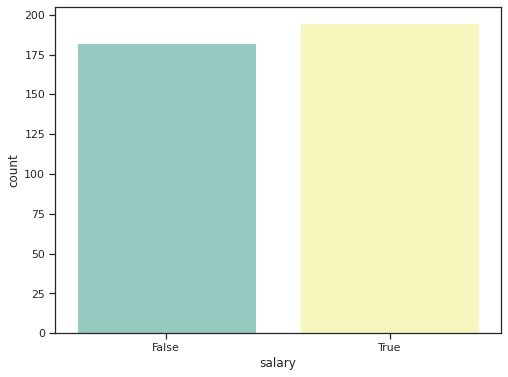

In [57]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()

In [58]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

51.72% of the data has salary information, should be an easy target


In [59]:
data.to_csv(f'../app/data/wrangled_data.csv', index=False)

In [60]:
data

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,recruiting from scratch,who is recruiting from scratch: recruiting fro...,"remote in huntsville, al",0.0,NaN,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...,who is recruiting from scratch: recruiting fro...,180000.0,2022-06-21,al,remote in huntsville
1,food management search,sr financial data analyst- fully remote - any ...,remote in united states,0.0,NaN,lead various allocation data analysis projects...,sr financial data analyst- fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,sr financial data analyst- fully remote - any ...,NaN,2022-06-21,remote in united states,remote in united states
2,gregor diagnostics,role: senior data scientistabout gregor diagno...,remote in united states,0.0,NaN,the senior data scientist will work closely la...,senior data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,role: senior data scientistabout gregor diagno...,NaN,2022-06-20,remote in united states,remote in united states
3,synergisticit,"at synergisticit, we aim to bring aboard it ...",alabama,4.2,NaN,"collaborate with dynamic teams of engineers, d...",entry level data scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...,"at synergisticit, we aim to bring aboard it ...",88000.0,2022-06-20,alabama,alabama
4,9rooftops,we are hiring in multiple locations across the...,"birmingham, al 35242",0.0,NaN,o communication skills to ask questions of cli...,statistician/data scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...,we are hiring in multiple locations across the...,124000.0,2022-06-20,al,birmingham
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,sanofi,overview at sanofi large molecule research pla...,"cambridge, ma 02238 (mid-cambridge area)+1 loc...",4.1,NaN,track record of applying machine learning/ dee...,principal data scientist machine learning for ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,overview at sanofi large molecule research pla...,NaN,2022-06-21,ma,cambridge
373,parexel,NaN,massachusetts,3.6,NaN,as a statistical programmer you will support v...,statistical programmer i (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,massachusetts,massachusetts
374,national grid co usa (ne power),NaN,"waltham, ma 02454",3.7,NaN,"employ sophisticated analytics, machine learni...","lead data scientist, data science",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,ma,waltham
375,parexel,NaN,massachusetts,3.6,NaN,the senior statistical programmer provides tec...,senior statistical programmer fsp (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,massachusetts,massachusetts


In [61]:
munged = data
munged

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,recruiting from scratch,who is recruiting from scratch: recruiting fro...,"remote in huntsville, al",0.0,NaN,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...,who is recruiting from scratch: recruiting fro...,180000.0,2022-06-21,al,remote in huntsville
1,food management search,sr financial data analyst- fully remote - any ...,remote in united states,0.0,NaN,lead various allocation data analysis projects...,sr financial data analyst- fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,sr financial data analyst- fully remote - any ...,NaN,2022-06-21,remote in united states,remote in united states
2,gregor diagnostics,role: senior data scientistabout gregor diagno...,remote in united states,0.0,NaN,the senior data scientist will work closely la...,senior data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,role: senior data scientistabout gregor diagno...,NaN,2022-06-20,remote in united states,remote in united states
3,synergisticit,"at synergisticit, we aim to bring aboard it ...",alabama,4.2,NaN,"collaborate with dynamic teams of engineers, d...",entry level data scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...,"at synergisticit, we aim to bring aboard it ...",88000.0,2022-06-20,alabama,alabama
4,9rooftops,we are hiring in multiple locations across the...,"birmingham, al 35242",0.0,NaN,o communication skills to ask questions of cli...,statistician/data scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...,we are hiring in multiple locations across the...,124000.0,2022-06-20,al,birmingham
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,sanofi,overview at sanofi large molecule research pla...,"cambridge, ma 02238 (mid-cambridge area)+1 loc...",4.1,NaN,track record of applying machine learning/ dee...,principal data scientist machine learning for ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,overview at sanofi large molecule research pla...,NaN,2022-06-21,ma,cambridge
373,parexel,NaN,massachusetts,3.6,NaN,as a statistical programmer you will support v...,statistical programmer i (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,massachusetts,massachusetts
374,national grid co usa (ne power),NaN,"waltham, ma 02454",3.7,NaN,"employ sophisticated analytics, machine learni...","lead data scientist, data science",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,ma,waltham
375,parexel,NaN,massachusetts,3.6,NaN,the senior statistical programmer provides tec...,senior statistical programmer fsp (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,massachusetts,massachusetts


In [62]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates and out of date posts leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

Droping 0 duplicates and out of date posts leaves 377 rows of data for the regressor to be trained and tested on.
- Of those 377 job postings 195 or 51.72% include salary information,
- The remaining 182 rows, or 48.28% are missing salary data.


## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

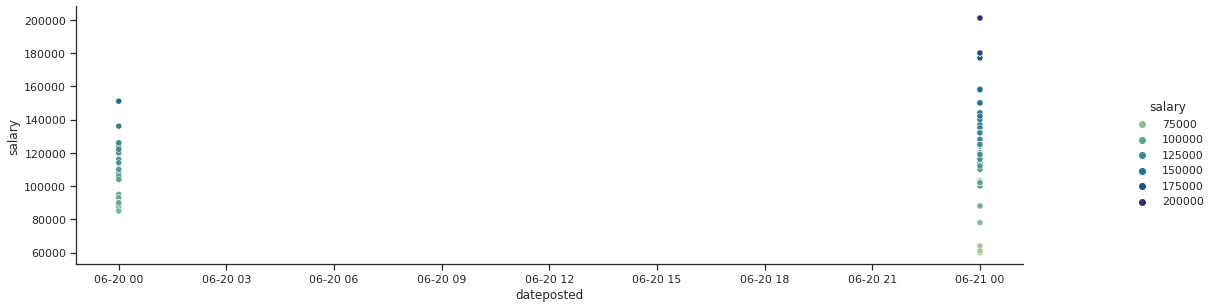

In [63]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.

In [64]:
outliers = []
def z_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

In [65]:
munged

,company,description,location,rating,requirements,summary,job_title,url,text,salary,dateposted,state,city
0,recruiting from scratch,who is recruiting from scratch: recruiting fro...,"remote in huntsville, al",0.0,NaN,5+ years experience in data engineering or dat...,data scientist,https://www.indeed.com/rc/clk?jk=977d1ccb6d1a1...,who is recruiting from scratch: recruiting fro...,180000.0,2022-06-21,al,remote in huntsville
1,food management search,sr financial data analyst- fully remote - any ...,remote in united states,0.0,NaN,lead various allocation data analysis projects...,sr financial data analyst- fully remote,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,sr financial data analyst- fully remote - any ...,NaN,2022-06-21,remote in united states,remote in united states
2,gregor diagnostics,role: senior data scientistabout gregor diagno...,remote in united states,0.0,NaN,the senior data scientist will work closely la...,senior data scientist,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,role: senior data scientistabout gregor diagno...,NaN,2022-06-20,remote in united states,remote in united states
3,synergisticit,"at synergisticit, we aim to bring aboard it ...",alabama,4.2,NaN,"collaborate with dynamic teams of engineers, d...",entry level data scientist,https://www.indeed.com/rc/clk?jk=57d47b0524890...,"at synergisticit, we aim to bring aboard it ...",88000.0,2022-06-20,alabama,alabama
4,9rooftops,we are hiring in multiple locations across the...,"birmingham, al 35242",0.0,NaN,o communication skills to ask questions of cli...,statistician/data scientist,https://www.indeed.com/rc/clk?jk=e23726e90096e...,we are hiring in multiple locations across the...,124000.0,2022-06-20,al,birmingham
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,sanofi,overview at sanofi large molecule research pla...,"cambridge, ma 02238 (mid-cambridge area)+1 loc...",4.1,NaN,track record of applying machine learning/ dee...,principal data scientist machine learning for ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,overview at sanofi large molecule research pla...,NaN,2022-06-21,ma,cambridge
373,parexel,NaN,massachusetts,3.6,NaN,as a statistical programmer you will support v...,statistical programmer i (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,massachusetts,massachusetts
374,national grid co usa (ne power),NaN,"waltham, ma 02454",3.7,NaN,"employ sophisticated analytics, machine learni...","lead data scientist, data science",https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,ma,waltham
375,parexel,NaN,massachusetts,3.6,NaN,the senior statistical programmer provides tec...,senior statistical programmer fsp (poland),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,NaN,NaN,2022-06-21,massachusetts,massachusetts


#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.

In [71]:
def iqr_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        return
    else:
        return outliers
x = iqr_detect(munged)


In [72]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

ValueError: min() arg is an empty sequence

In [ ]:
# Take a look at those tables.

outliers = munged[munged['salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

In [ ]:
null = len(munged[munged.salary.isnull()])

nnull = len(munged[munged.salary.notnull()])

In [ ]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

In [ ]:
sns.countplot(x='salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [ ]:
munged.info()

In [ ]:
munged.to_csv(f'../app/data/wrangled_data.csv', index=False)

In [ ]:
munged.info()

In [ ]:
munged.info(memory_usage='deep')

In [ ]:
munged.drop('location',inplace=True,axis=1)

In [ ]:
munged.info(memory_usage='deep')